In [82]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt

In [83]:
import numpy as np
import pandas as pd
import os

# Reflect Tables into SQLAlchemy ORM

In [84]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [85]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [86]:
# reflect an existing database into a new model
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)

In [87]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [88]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [89]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [90]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [91]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [92]:
# Calculate the date 1 year ago from the last data point in the database
# knowing the last data from above, hardwire in the querry a time stamp 1-year from.
Precip_OneYear = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date > '2016-08-23').\
                        order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
Precip_df = pd.DataFrame(Precip_OneYear, columns=['date', 'prcp'])

# Sort the dataframe by date
Precip_df.set_index(Precip_df['date'])
Precip_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


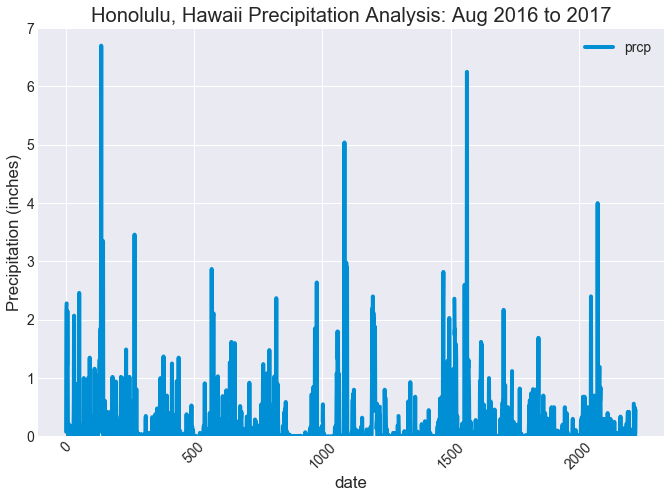

In [93]:
# Use Pandas Plotting with Matplotlib to plot the data
#Plot the results using the DataFrame plot method.
sns.set_style(style="darkgrid")
fig, ax = plt.subplots(figsize=(10,7))
Precip_df.plot(ax=ax)

#set major ticks format
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_ylim(0,max(Precip_df['prcp']+.3))
ax.set_title("Honolulu, Hawaii Precipitation Analysis: Aug 2016 to 2017")
ax.set_ylabel("Precipitation (inches)")
ax.set_xlabel("date")
plt.xticks(rotation=45)
plt.show()

In [94]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [95]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.name)).all()

[(9)]

In [106]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
#Use Pandas `read_sql_query` to load a query statement directly into the DataFrame
#engine.execute('SELECT * FROM Station').fetchall()
#last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
Active = session.query(Measurement.station, Station.name, func.count(Measurement.id)).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).statement

#write into DataFrame
dfActive = pd.read_sql_query(Active, session.bind)

#Most Active Stations Number
MostActive_Sta = dfActive["station"][0]
#Most Active Stations Name
MostActive_StaName = dfActive['name'][0]
#highest number of observation
StaObs = dfActive['count_1'][0]

print(f"Station #{MostActive_StaName}-'{MostActive_Sta}' has the highest number of observations: {StaObs}.")

# List the full list of stations
dfActive

Station #WAIHEE 837.5, HI US-'USC00519281' has the highest number of observations: 2772.


,station,name,count_1
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [134]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
TempQuery = session.query(Station.id,Station.name,func.min(Measurement.tobs),func.max(Measurement.tobs),
            func.avg(Measurement.tobs))\
            .filter(Measurement.station == Station.station)\
            .filter(Measurement.station == "USC00519281")

Avg_tmp = "{0:.1f}".format(TempQuery[0][4])

print(f"Most Active Station Name: {MostActive_StaName}, Location: {TempQuery[0][1]} \nResults:\
      \nMinimum temperature recorded: {TempQuery[0][2]}\
      \nMaximum temperature recorded: {TempQuery[0][3]}\
      \nAverage temperature recorded: {Avg_tmp}")

Most Active Station Name: WAIHEE 837.5, HI US, Location: WAIHEE 837.5, HI US 
Results:      
Minimum temperature recorded: 54.0      
Maximum temperature recorded: 85.0      
Average temperature recorded: 71.7


In [138]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
TObs = session.query(Measurement.tobs)\
    .filter(Measurement.date > '2016-08-23')\
    .filter(Measurement.station == "USC00519281")\
    .order_by(Measurement.tobs).all()

TObs_df = pd.DataFrame(TObs, columns=['temp'])
TObs_df.head()

,temp
0,59.0
1,59.0
2,59.0
3,60.0
4,60.0


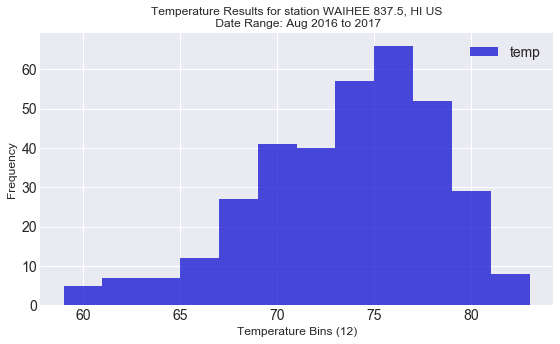

In [140]:
plt.subplots(figsize=(8,5))

plt.hist(TObs_df['temp'], bins=12, color="mediumblue", alpha=.7)
plt.title(f"Temperature Results for station {MostActive_StaName}\n Date Range: Aug 2016 to 2017",fontsize=12)
plt.xlabel('Temperature Bins (12)', fontsize=12)
plt.ylabel("Frequency", fontsize=12)
labels = ['temp']
plt.legend(labels)
plt.gcf().subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.show()

In [141]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [143]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2015-08-23', '2016-08-23'))

[(56.0, 74.45063829787235, 86.0)]


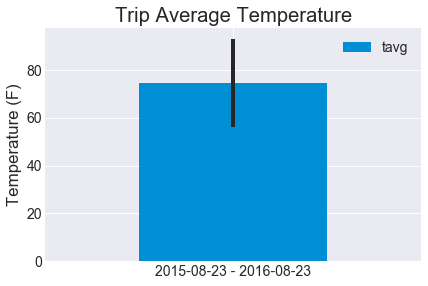

In [145]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
Sdate = '2015-08-23'
Edate = '2016-08-23'
Drange = Sdate + ' - ' + Edate
tmin,tavg,tmax = calc_temps(Sdate, Edate)[0]
tavg_df=pd.DataFrame([tavg],columns=['tavg'],index=[Drange])

tavg_df.plot(kind='bar',yerr=[[tavg-tmin],[tmax-tavg]])
plt.xticks(rotation='horizontal')
plt.ylabel('Temperature (F)')
plt.title('Trip Average Temperature')
plt.show()

In [151]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
RainFall = session.query(Station.station,
                  func.sum(Measurement.prcp),
                  Station.name,
                  Station.elevation,                                    
                  Station.latitude,
                  Station.longitude)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= '2015-08-23')\
.filter(Measurement.date <= '2016-08-23')\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc())

print()
print (f"Historical Rainfall Per Weather Station - Descending order\
         \nSearch Dates: {'2015-08-23'} - {'2016-08-23'}")
print()
for row in RainFall:
    rain="{0:.2f}".format(row[1])
    print (f"Station:  {row[0]}\n    Rainfall:  {rain}  \n    Location:  {row[2]}\n    Elevation:  {row[3]}  \
    Latitude:  {row[4]}  Longitude:  {row[5]}")
    print()


Historical Rainfall Per Weather Station - Descending order         
Search Dates: 2015-08-23 - 2016-08-23

Station:  USC00516128
    Rainfall:  177.99  
    Location:  MANOA LYON ARBO 785.2, HI US
    Elevation:  152.4      Latitude:  21.3331  Longitude:  -157.8025

Station:  USC00519281
    Rainfall:  108.56  
    Location:  WAIHEE 837.5, HI US
    Elevation:  32.9      Latitude:  21.45167  Longitude:  -157.84888999999998

Station:  USC00513117
    Rainfall:  72.59  
    Location:  KANEOHE 838.1, HI US
    Elevation:  14.6      Latitude:  21.4234  Longitude:  -157.8015

Station:  USC00519523
    Rainfall:  55.58  
    Location:  WAIMANALO EXPERIMENTAL FARM, HI US
    Elevation:  19.5      Latitude:  21.33556  Longitude:  -157.71139

Station:  USC00514830
    Rainfall:  42.98  
    Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US
    Elevation:  7.0      Latitude:  21.5213  Longitude:  -157.8374

Station:  USC00519397
    Rainfall:  23.80  
    Location:  WAIKIKI 717.2, HI US
    Ele

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
